# Load data

In [1]:
import pandas as pd

In [1]:
from tqdm.auto import tqdm, trange
import random
import os

In [2]:
all_sents = []
folder = 'C:/Users/david/Documents/nlp/leipzig-corpora/'
for fn in os.listdir(folder):
    with open(folder + fn, 'r') as f:
        for line in tqdm(f):
            text = line.strip().split('\t', 1)[1]
            all_sents.append(text)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [3]:
print(len(all_sents))

3000000


In [4]:
for _ in range(5):
    print(random.choice(all_sents))

Валерий Жарков рассказал, что владельцы 10 из 12 домов могут уже сейчас воспользоваться компенсацией, приобрести новое жилье.
С 31 мая для ремонта закрыто отделение связи 620027 (Екатеринбург, улица Мельковская, 2б).
Мы доставляем дренажные трубы в конкуренцию ЖБИ, но обходятся.
Он представлял граждан Ваилики и соседних городов Мауи.
Для живого человека очень важна стабильность жизненного уклада, устоявшееся существование.


# Create a tokenizer

In [5]:
# I don't like BART tokenizer, because it is byte-level
# I don't like T5 tokenizer, because it uses crazy tokens
# from transformers import BartTokenizerFast, BartForConditionalGeneration, BartConfig
from transformers import T5TokenizerFast, T5ForConditionalGeneration, T5Config

In [6]:
old_tokenizer = T5TokenizerFast.from_pretrained('t5-small', model_max_length=512)

In [7]:
old_tokenizer('hello world')

{'input_ids': [21820, 296, 1], 'attention_mask': [1, 1, 1]}

In [8]:
def batch_iterator(batch_size=10000):
    for i in tqdm(range(0, len(all_sents), batch_size)):
        yield all_sents[i : i + batch_size]

In [9]:
tokenizer = old_tokenizer.train_new_from_iterator(text_iterator=batch_iterator(), vocab_size=32768)

  0%|          | 0/300 [00:00<?, ?it/s]

In [10]:
tokenizer

T5TokenizerFast(name_or_path='t5-small', vocab_size=32768, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>', '<extra_id_43>', '<extra_i

In [11]:
tokenizer('hello world')

{'input_ids': [103, 1395, 5918, 603, 103, 1142, 1669, 854, 959, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [12]:
tokenizer.tokenize(random.choice(all_sents))

['▁Так',
 ',',
 '▁',
 'например,',
 '▁спутник',
 '▁"С',
 'ич',
 '-3',
 '-О',
 '"',
 '▁способен',
 '▁"',
 'рас',
 'смотреть',
 '"',
 '▁на',
 '▁земле',
 '▁во',
 '▁время',
 '▁',
 'съемок',
 '▁объекты',
 '▁размерам',
 'и',
 '▁в',
 '▁',
 '0,5',
 '▁метра',
 ',',
 '▁что',
 '▁позволяет',
 '▁фиксировать',
 '▁любую',
 '▁от',
 'дельную',
 '▁единиц',
 'у',
 '▁техники',
 '▁или',
 '▁скоплени',
 'я',
 '▁людей',
 '.']

In [14]:
import pandas as pd

In [15]:
lens = pd.Series([len(tokenizer.tokenize(t)) for t in tqdm(random.sample(all_sents, 10000))])
lens.describe()

  0%|          | 0/10000 [00:00<?, ?it/s]

count    10000.000000
mean        23.312600
std         11.636194
min          4.000000
25%         14.000000
50%         21.000000
75%         30.000000
max         82.000000
dtype: float64

In [16]:
lens.quantile([0.9, 0.99, 0.999])

0.900    40.0
0.990    57.0
0.999    71.0
dtype: float64

# Initialize a model

In [17]:
cfg = T5Config(
    vocab_size=len(tokenizer),
    d_model=128,
    num_layers=3,
    num_heads=8,
    d_kv=16,
    d_ff=512,
    #feed_forward_proj='gated-gelu',
    decoder_start_token_id=tokenizer.pad_token_id,
)

In [18]:
cfg

T5Config {
  "d_ff": 512,
  "d_kv": 16,
  "d_model": 128,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "num_decoder_layers": 3,
  "num_heads": 8,
  "num_layers": 3,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.26.1",
  "use_cache": true,
  "vocab_size": 32768
}

In [19]:
model = T5ForConditionalGeneration(cfg)

In [20]:
tokenizer

T5TokenizerFast(name_or_path='t5-small', vocab_size=32768, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>', '<extra_id_43>', '<extra_i

In [21]:
MODEL_SAVE_PATH = '../models/t5-tiny-rus'

In [22]:
model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

('../models/t5-tiny-rus\\tokenizer_config.json',
 '../models/t5-tiny-rus\\special_tokens_map.json',
 '../models/t5-tiny-rus\\tokenizer.json')

The 128\*3 model occupies only 22MB on disk, which is indeed extremely tiny. I hope it'll train super fast. 

# Define the training task

In [26]:
text = random.choice(all_sents)
text

'Так, путевку на черноморское побережье рассмотрели бы 23 процента респондентов.'

In [24]:
def fill_gap_task(text=None, min_sent_len=3, p_num_words=0.5, left_pad=0, right_pad=0, mask_token='<extra_id_0>'):
    if text is None:
        text = random.choice(all_sents)
    words = text.split()
    if len(words) < min_sent_len:
        return fill_gap_task()
    # to choose between all substrings uniformly, pick both ends uniformly and re-pick if the order is incorrect.
    left_id, right_id = 1, -1
    while left_id > right_id:
        left_id, right_id = [random.randint(left_pad, len(words)-1-right_pad) for _ in range(2)]
    #left_id = random.randint(left_pad, right_id)
    if random.random() > p_num_words:
        filler = [mask_token]
    else:
        filler = [mask_token.replace('0', str(right_id-left_id+1))]
    lhs = ' '.join(words[:left_id] + filler + words[right_id+1:])
    rhs = ' '.join(words[left_id:(right_id+1)])
    return lhs, rhs

In [27]:
from collections import Counter

for t in sorted([(x, y, c) for (x, y), c in Counter(fill_gap_task(text, p_num_words=0) for _ in range(10000)).most_common()]):
    print(t)

('<extra_id_0>', 'Так, путевку на черноморское побережье рассмотрели бы 23 процента респондентов.', 181)
('<extra_id_0> 23 процента респондентов.', 'Так, путевку на черноморское побережье рассмотрели бы', 185)
('<extra_id_0> бы 23 процента респондентов.', 'Так, путевку на черноморское побережье рассмотрели', 165)
('<extra_id_0> на черноморское побережье рассмотрели бы 23 процента респондентов.', 'Так, путевку', 193)
('<extra_id_0> побережье рассмотрели бы 23 процента респондентов.', 'Так, путевку на черноморское', 210)
('<extra_id_0> процента респондентов.', 'Так, путевку на черноморское побережье рассмотрели бы 23', 166)
('<extra_id_0> путевку на черноморское побережье рассмотрели бы 23 процента респондентов.', 'Так,', 202)
('<extra_id_0> рассмотрели бы 23 процента респондентов.', 'Так, путевку на черноморское побережье', 177)
('<extra_id_0> респондентов.', 'Так, путевку на черноморское побережье рассмотрели бы 23 процента', 178)
('<extra_id_0> черноморское побережье рассмотрели бы 23

# Training

In [28]:
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor, AdamW
from transformers import get_linear_schedule_with_warmup, get_constant_schedule_with_warmup

import gc
import numpy as np

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [29]:
model.cuda();

In [30]:
optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],  
    lr=1e-3,
    weight_decay=1e-3,
)

In [31]:
batch_size = 16 # we can get even more, but training gets slow
max_length = 128
warmup_steps = 5_000
training_steps = 500_000

In [32]:
losses = []

In [33]:
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [34]:
def get_batch_pairs(batch_size, p=0.2):
    xx, yy = [], []
    for text in random.sample(all_sents, batch_size):
        x, y = fill_gap_task(text, p_num_words=p)
        xx.append(x)
        yy.append(y)
    return xx, yy

In [35]:
get_batch_pairs(3)

(['Самат просто не успел бы набрать <extra_id_0>',
  'Другое дело, что за <extra_id_9> футболистов команды за всю историю.',
  'При <extra_id_0> сам он заранее объявил ничтожными.'],
 ['скорость от борта.',
  'два года в «Страсбуре» я вошел в тройку лучших',
  'этом письменные гарантии, которых добивается Путин,'])

In [36]:
# optimizer.param_groups[0]['lr'] = 1e-3  # did this at about 43k step\s

In [204]:
model.train()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy = get_batch_pairs(batch_size)
    try:
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == 0] = -100
        
        loss = model(**x, labels=y.input_ids).loss

        loss.backward()
        losses.append(loss.item())

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy))
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 10000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/281541 [00:00<?, ?it/s]

219000 5.914654289722443
220000 5.939964764118194
221000 5.933440552711486
222000 5.9295474691390995
223000 5.918973770618439
224000 5.917738650798798
225000 5.926275660037994
226000 5.916566464424133
227000 5.919402430057525
228000 5.91241503572464
229000 5.898568385124206
230000 5.903127415180206
231000 5.908620546340942
232000 5.908520577907562
233000 5.914320600032807
234000 5.9057949681282045
235000 5.897089570999145
236000 5.90353200340271
237000 5.923386028289795
238000 5.906109364509582
239000 5.896291173458099
240000 5.902187224388123
241000 5.904820619106292
242000 5.897431979656219
243000 5.905068331718445
244000 5.897102338790893
245000 5.899725223064423
246000 5.884846350669861
247000 5.881538531303406
248000 5.887169295310974
249000 5.890198337554931
250000 5.879228580951691
251000 5.878526999473571
252000 5.873649899482727
253000 5.880397706508637
254000 5.883304214954376
255000 5.8751353282928465
256000 5.857736214160919
257000 5.885882164955139
258000 5.85322811460495


500000


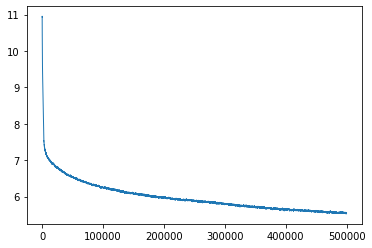

In [205]:
print(len(losses))
pd.Series(losses).ewm(300).mean()[10:].plot(lw=1);

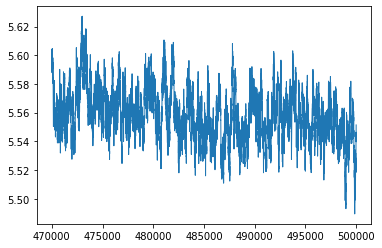

In [206]:
pd.Series(losses).ewm(100).mean()[-30000:].plot(lw=1);

In [226]:
sent = random.choice(all_sents)
sent

'Это вполне нормально, потому что потом эти вредные привычки тяжелым грузом ложатся на систему здравоохранения», - сказал член-корреспондент РАН.'

In [227]:
xx, yy = fill_gap_task(sent, p_num_words=0.5)
print(xx)
print(yy)

Это <extra_id_2> потому что потом эти вредные привычки тяжелым грузом ложатся на систему здравоохранения», - сказал член-корреспондент РАН.
вполне нормально,


In [228]:
model.eval();

with torch.inference_mode():
    x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
    for _ in range(5):
        print(tokenizer.decode(model.generate(**x, num_beams=2, do_sample=True)[0]))

<pad> что в</s>
<pad> о том, что</s>
<pad> на Украине, что</s>
<pad> о том, что</s>
<pad> а также</s>


In [229]:
print(tokenizer.tokenize(xx))

['▁Это', '<extra_id_2>', '▁потому', '▁что', '▁потом', '▁эти', '▁', 'вредные', '▁привычк', 'и', '▁тяжелым', '▁груз', 'ом', '▁', 'ложат', 'ся', '▁на', '▁систему', '▁здравоохранения', '»,', '▁-', '▁сказал', '▁член', '-корреспондент', '▁РАН', '.']


# An experiment: how far would we go with a much larger model?

In [230]:
cfg2 = T5Config(
    vocab_size=len(tokenizer),
    d_model=512,
    num_layers=6,
    num_heads=8,
    d_kv=64,
    d_ff=512,
    #feed_forward_proj='gated-gelu',
    decoder_start_token_id=tokenizer.pad_token_id,
)

In [231]:
model2 = T5ForConditionalGeneration(cfg2)

In [232]:
MODEL_SAVE_PATH2 = '../models/t5-small-rus'

In [233]:
model2.save_pretrained(MODEL_SAVE_PATH2)
tokenizer.save_pretrained(MODEL_SAVE_PATH2)

('../models/t5-small-rus\\tokenizer_config.json',
 '../models/t5-small-rus\\special_tokens_map.json',
 '../models/t5-small-rus\\tokenizer.json')

In [234]:
model2.cuda();

In [ ]:
optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],  
    lr=1e-3,
    weight_decay=1e-3,
)